# Multigroup Cross Section Generation Part II: Advanced Features
This IPython Notebook illustrates the use of the `openmc.mgxs` module to calculate multi-group cross sections for a heterogeneous fuel pin cell geometry. In particular, this Notebook illustrates the following features:

* Creation of multi-group cross sections on a **heterogeneous geometry**
* Calculation of cross sections on a **nuclide-by-nuclide basis**
* The use of **[tally precision triggers](../io_formats/settings.rst#trigger-element)** with multi-group cross sections
* Built-in features for **energy condensation** in downstream data processing
* The use of the **`openmc.data`** module to plot continuous-energy vs. multi-group cross sections
* **Validation** of multi-group cross sections with **[OpenMOC](https://mit-crpg.github.io/OpenMOC/)**

**Note:** This Notebook was created using [OpenMOC](https://mit-crpg.github.io/OpenMOC/) to verify the multi-group cross-sections generated by OpenMC. You must install [OpenMOC](https://mit-crpg.github.io/OpenMOC/) on your system in order to run this Notebook in its entirety. In addition, this Notebook illustrates the use of [Pandas](https://pandas.pydata.org/) `DataFrames` to containerize multi-group cross section data.

## Generate Input Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import openmoc

import openmc
import openmc.mgxs as mgxs
import openmc.data
from openmc.openmoc_compatible import get_openmoc_geometry

%matplotlib inline

In [2]:
# create a model object to tie together geometry, materials, settings, and tallies
model = openmc.Model()

First we need to define materials that will be used in the problem. We'll create three distinct materials for water, clad and fuel.

In [3]:
# 1.6% enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide('U235', 3.7503e-4)
fuel.add_nuclide('U238', 2.2625e-2)
fuel.add_nuclide('O16', 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 4.9457e-2)
water.add_nuclide('O16', 2.4732e-2)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

With our materials, we can now create a `Materials` object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection
model.materials = openmc.Materials([fuel, water, zircaloy])

Now let's move on to the geometry. Our problem will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces -- in this case two cylinders and six reflective planes.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.45720)

# Create box to surround the geometry
box = openmc.model.rectangular_prism(1.26, 1.26, boundary_type='reflective')

With the surfaces defined, we can now create cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius & box
pin_cell_universe.add_cell(moderator_cell)

We now must create a geometry with the pin cell universe and export it to XML.

In [7]:
# Create Geometry and set root Universe
model.geometry = openmc.Geometry(pin_cell_universe)

Next, we must define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 10,000 particles.

In [8]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 10000

# Instantiate a Settings object
settings = openmc.Settings()
settings.batches = batches
settings.inactive = inactive
settings.particles = particles
settings.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.Source(space=uniform_dist)

# Activate tally precision triggers
settings.trigger_active = True
settings.trigger_max_batches = settings.batches * 4

model.settings = settings

Now we are finally ready to make use of the `openmc.mgxs` module to generate multi-group cross sections! First, let's define "coarse" 2-group and "fine" 8-group structures using the built-in `EnergyGroups` class.

In [9]:
# Instantiate a "coarse" 2-group EnergyGroups object
coarse_groups = mgxs.EnergyGroups([0., 0.625, 20.0e6])

# Instantiate a "fine" 8-group EnergyGroups object
fine_groups = mgxs.EnergyGroups([0., 0.058, 0.14, 0.28,
                                 0.625, 4.0, 5.53e3, 821.0e3, 20.0e6])

Now we will instantiate a variety of `MGXS` objects needed to run an OpenMOC simulation to verify the accuracy of our cross sections. In particular, we define transport, fission, nu-fission, nu-scatter and chi cross sections for each of the three cells in the fuel pin with the 8-group structure as our energy groups.

In [10]:
# Extract all Cells filled by Materials
openmc_cells = model.geometry.get_all_material_cells().values()

# Create dictionary to store multi-group cross sections for all cells
xs_library = {}

# Instantiate 8-group cross sections for each cell
for cell in openmc_cells:
    xs_library[cell.id] = {}
    xs_library[cell.id]['transport']  = mgxs.TransportXS(energy_groups=fine_groups)
    xs_library[cell.id]['fission'] = mgxs.FissionXS(energy_groups=fine_groups)
    xs_library[cell.id]['nu-fission'] = mgxs.FissionXS(energy_groups=fine_groups, nu=True)
    xs_library[cell.id]['nu-scatter'] = mgxs.ScatterMatrixXS(energy_groups=fine_groups, nu=True)
    xs_library[cell.id]['chi'] = mgxs.Chi(energy_groups=fine_groups)

Next, we showcase the use of OpenMC's [tally precision trigger](../io_formats/settings.rst#trigger-element) feature in conjunction with the `openmc.mgxs` module. In particular, we will assign a tally trigger of 1E-2 on the standard deviation for each of the tallies used to compute multi-group cross sections.

In [11]:
# Create a tally trigger for +/- 0.01 on each tally used to compute the multi-group cross sections
tally_trigger = openmc.Trigger('std_dev', 1e-2)

# Add the tally trigger to each of the multi-group cross section tallies
for cell in openmc_cells:
    for mgxs_type in xs_library[cell.id]:
        xs_library[cell.id][mgxs_type].tally_trigger = tally_trigger

Now, we must loop over all cells to set the cross section domains to the various cells - fuel, clad and moderator - included in the geometry. In addition, we will set each cross section to tally cross sections on a per-nuclide basis through the use of the `MGXS` class' boolean `by_nuclide` instance attribute.  

In [12]:
# Instantiate an empty Tallies object
tallies = openmc.Tallies()

# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id]:

        # Set the cross sections domain to the cell
        xs_library[cell.id][rxn_type].domain = cell
        
        # Tally cross sections by nuclide
        xs_library[cell.id][rxn_type].by_nuclide = True
                
        # Add OpenMC tallies to the tallies file for XML generation
        for tally in xs_library[cell.id][rxn_type].tallies.values():
            tallies.append(tally, merge=True)
            
model.tallies = tallies

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [13]:
# Run OpenMC
sp_file = model.run()

/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=53.
  warn(msg, IDWarning)
/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=21.
  warn(msg, IDWarning)
/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=41.


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [14]:
# Load the last statepoint file
sp = openmc.StatePoint(sp_file)

The statepoint is now ready to be analyzed by our multi-group cross sections. We simply have to load the tallies from the `StatePoint` into each object as follows and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [15]:
# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id]:
        xs_library[cell.id][rxn_type].load_from_statepoint(sp)

That's it! Our multi-group cross sections are now ready for the big spotlight. This time we have cross sections in three distinct spatial zones - fuel, clad and moderator - on a per-nuclide basis.

## Extracting and Storing MGXS Data

Let's first inspect one of our cross sections by printing it to the screen as a microscopic cross section in units of barns.

In [16]:
nufission = xs_library[fuel_cell.id]['nu-fission']
nufission.print_xs(xs_type='micro', nuclides=['U235', 'U238'])

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	1
	Nuclide        =	U235
	Cross Sections [barns]:
            Group 1 [821000.0   - 20000000.0eV]:	3.30e+00 +/- 2.34e-01%
            Group 2 [5530.0     - 821000.0  eV]:	3.96e+00 +/- 1.53e-01%
            Group 3 [4.0        - 5530.0    eV]:	5.52e+01 +/- 2.15e-01%
            Group 4 [0.625      - 4.0       eV]:	8.83e+01 +/- 3.51e-01%
            Group 5 [0.28       - 0.625     eV]:	2.90e+02 +/- 5.28e-01%
            Group 6 [0.14       - 0.28      eV]:	4.49e+02 +/- 4.05e-01%
            Group 7 [0.058      - 0.14      eV]:	6.87e+02 +/- 3.36e-01%
            Group 8 [0.0        - 0.058     eV]:	1.44e+03 +/- 2.54e-01%

	Nuclide        =	U238
	Cross Sections [barns]:
            Group 1 [821000.0   - 20000000.0eV]:	1.06e+00 +/- 2.64e-01%
            Group 2 [5530.0     - 821000.0  eV]:	1.21e-03 +/- 2.83e-01%
            Group 3 [4.0        - 5530.0    eV]:	5.51e-04 +/- 2.99e+00%
            Group 4 [0.6

Our multi-group cross sections are capable of summing across all nuclides to provide us with macroscopic cross sections as well.

In [17]:
nufission = xs_library[fuel_cell.id]['nu-fission']
nufission.print_xs(xs_type='macro', nuclides='sum')

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	1
	Cross Sections [cm^-1]:
            Group 1 [821000.0   - 20000000.0eV]:	2.52e-02 +/- 2.51e-01%
            Group 2 [5530.0     - 821000.0  eV]:	1.51e-03 +/- 1.50e-01%
            Group 3 [4.0        - 5530.0    eV]:	2.07e-02 +/- 2.14e-01%
            Group 4 [0.625      - 4.0       eV]:	3.31e-02 +/- 3.51e-01%
            Group 5 [0.28       - 0.625     eV]:	1.09e-01 +/- 5.28e-01%
            Group 6 [0.14       - 0.28      eV]:	1.69e-01 +/- 4.05e-01%
            Group 7 [0.058      - 0.14      eV]:	2.58e-01 +/- 3.36e-01%
            Group 8 [0.0        - 0.058     eV]:	5.40e-01 +/- 2.54e-01%





Although a printed report is nice, it is not scalable or flexible. Let's extract the microscopic cross section data for the moderator as a [Pandas](https://pandas.pydata.org/) `DataFrame` .

In [18]:
nuscatter = xs_library[moderator_cell.id]['nu-scatter']
df = nuscatter.get_pandas_dataframe(xs_type='micro')
df.head(10)

,cell,group in,group out,nuclide,mean,std. dev.
126,3,1,1,H1,0.233979,0.003921
127,3,1,1,O16,1.566955,0.006599
124,3,1,2,H1,1.589223,0.003224
125,3,1,2,O16,0.286382,0.001478
122,3,1,3,H1,0.011405,0.000244
123,3,1,3,O16,0.000000,0.000000
120,3,1,4,H1,0.000015,0.000009
121,3,1,4,O16,0.000000,0.000000
118,3,1,5,H1,0.000005,0.000005
119,3,1,5,O16,0.000000,0.000000


Next, we illustate how one can easily take multi-group cross sections and condense them down to a coarser energy group structure. The `MGXS` class includes a `get_condensed_xs(...)` method which takes an `EnergyGroups` parameter with a coarse(r) group structure and returns a new `MGXS` condensed to the coarse groups. We illustrate this process below using the 2-group structure created earlier.

In [19]:
# Extract the 8-group transport cross section for the fuel
fine_xs = xs_library[fuel_cell.id]['transport']

# Condense to the 2-group structure
condensed_xs = fine_xs.get_condensed_xs(coarse_groups)

Group condensation is as simple as that! We now have a new coarse 2-group `TransportXS` in addition to our original 8-group `TransportXS`. Let's inspect the 2-group `TransportXS` by printing it to the screen and extracting a Pandas `DataFrame` as we have already learned how to do.

In [20]:
condensed_xs.print_xs()

Multi-Group XS
	Reaction Type  =	transport
	Domain Type    =	cell
	Domain ID      =	1
	Nuclide        =	U235
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	7.77e-03 +/- 2.18e-01%
            Group 2 [0.0        - 0.625     eV]:	1.82e-01 +/- 1.85e-01%

	Nuclide        =	U238
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	2.17e-01 +/- 1.32e-01%
            Group 2 [0.0        - 0.625     eV]:	2.53e-01 +/- 1.91e-01%

	Nuclide        =	O16
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	1.45e-01 +/- 1.26e-01%
            Group 2 [0.0        - 0.625     eV]:	1.74e-01 +/- 2.02e-01%





In [21]:
df = condensed_xs.get_pandas_dataframe(xs_type='micro')
df

,cell,group in,nuclide,mean,std. dev.
3,1,1,U235,20.715441,0.045146
4,1,1,U238,9.579757,0.012606
5,1,1,O16,3.155966,0.003977
0,1,2,U235,485.656482,0.899766
1,1,2,U238,11.191961,0.021372
2,1,2,O16,3.790699,0.007656


## Verification with OpenMOC

Now, let's verify our cross sections using OpenMOC. First, we construct an equivalent OpenMOC geometry.

In [22]:
# Create an OpenMOC Geometry from the OpenMC Geometry
openmoc_geometry = get_openmoc_geometry(sp.summary.geometry)

Next, we we can inject the multi-group cross sections into the equivalent fuel pin cell OpenMOC geometry.

In [23]:
# Get all OpenMOC cells in the gometry
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
for cell_id, cell in openmoc_cells.items():
    
    # Ignore the root cell
    if cell.getName() == 'root cell':
        continue
    
    # Get a reference to the Material filling this Cell
    openmoc_material = cell.getFillMaterial()
    
    # Set the number of energy groups for the Material
    openmoc_material.setNumEnergyGroups(fine_groups.num_groups)
    
    # Extract the appropriate cross section objects for this cell
    transport = xs_library[cell_id]['transport']
    nufission = xs_library[cell_id]['nu-fission']
    nuscatter = xs_library[cell_id]['nu-scatter']
    chi = xs_library[cell_id]['chi']
    
    # Inject NumPy arrays of cross section data into the Material
    # NOTE: Sum across nuclides to get macro cross sections needed by OpenMOC
    openmoc_material.setSigmaT(transport.get_xs(nuclides='sum').flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs(nuclides='sum').flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs(nuclides='sum').flatten())
    openmoc_material.setChi(chi.get_xs(nuclides='sum').flatten())

We are now ready to run OpenMOC to verify our cross-sections from OpenMC.

In [24]:
# Generate tracks for OpenMOC
track_generator = openmoc.TrackGenerator(openmoc_geometry, num_azim=128, azim_spacing=0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Initializing a default angular quadrature...
[  NORMAL ]  Initializing 2D tracks...
[  NORMAL ]  Initializing 2D tracks reflections...
[  NORMAL ]  Initializing 2D tracks array...
[  NORMAL ]  Ray tracing for 2D track segmentation...
[  NORMAL ]  Progress Segmenting 2D tracks: 0.09 %
[  NORMAL ]  Progress Segmenting 2D tracks: 10.02 %
[  NORMAL ]  Progress Segmenting 2D tracks: 19.94 %
[  NORMAL ]  Progress Segmenting 2D tracks: 29.87 %
[  NORMAL ]  Progress Segmenting 2D tracks: 39.80 %
[  NORMAL ]  Progress Segmenting 2D tracks: 49.72 %
[  NORMAL ]  Progress Segmenting 2D tracks: 59.65 %
[  NORMAL ]  Progress Segmenting 2D tracks: 69.58 %
[  NORMAL ]  Progress Segmenting 2D tracks: 79.50 %
[  NORMAL ]  Progress Segmenting 2D tracks: 89.43 %
[  NORMAL ]  Progress Segmenting 2D tracks: 100.00 %
[  NORMAL ]  Initializing FSR lookup vectors
[  NORMAL ]  Total number of FSRs 3
[  NORMAL ]  Initializing MOC eigenvalue solver...
[  NORMAL ]  Initializing solver arrays...
[  NOR

We report the eigenvalues computed by OpenMC and OpenMOC here together to summarize our results.

In [25]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined.n
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.222044
openmoc keff = 1.218846
bias [pcm]: -319.8


/home/pshriwise/.pyenv/versions/3.9.1/lib/python3.9/site-packages/openmc/statepoint.py:277: FutureWarning: The 'k_combined' property has been renamed to 'keff' and will be removed in a future version of OpenMC.
  warnings.warn(


As a sanity check, let's run a simulation with the coarse 2-group cross sections to ensure that they also produce a reasonable result.

In [26]:
openmoc_geometry = get_openmoc_geometry(sp.summary.geometry)
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
for cell_id, cell in openmoc_cells.items():
    
    # Ignore the root cell
    if cell.getName() == 'root cell':
        continue
    
    openmoc_material = cell.getFillMaterial()
    openmoc_material.setNumEnergyGroups(coarse_groups.num_groups)
    
    # Extract the appropriate cross section objects for this cell
    transport = xs_library[cell_id]['transport']
    nufission = xs_library[cell_id]['nu-fission']
    nuscatter = xs_library[cell_id]['nu-scatter']
    chi = xs_library[cell_id]['chi']
    
    # Perform group condensation
    transport = transport.get_condensed_xs(coarse_groups)
    nufission = nufission.get_condensed_xs(coarse_groups)
    nuscatter = nuscatter.get_condensed_xs(coarse_groups)
    chi = chi.get_condensed_xs(coarse_groups)
    
    # Inject NumPy arrays of cross section data into the Material
    openmoc_material.setSigmaT(transport.get_xs(nuclides='sum').flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs(nuclides='sum').flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs(nuclides='sum').flatten())
    openmoc_material.setChi(chi.get_xs(nuclides='sum').flatten())

In [27]:
# Generate tracks for OpenMOC
track_generator = openmoc.TrackGenerator(openmoc_geometry, num_azim=128, azim_spacing=0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Initializing a default angular quadrature...
[  NORMAL ]  Initializing 2D tracks...
[  NORMAL ]  Initializing 2D tracks reflections...
[  NORMAL ]  Initializing 2D tracks array...
[  NORMAL ]  Ray tracing for 2D track segmentation...
[  NORMAL ]  Progress Segmenting 2D tracks: 0.09 %
[  NORMAL ]  Progress Segmenting 2D tracks: 10.02 %
[  NORMAL ]  Progress Segmenting 2D tracks: 19.94 %
[  NORMAL ]  Progress Segmenting 2D tracks: 29.87 %
[  NORMAL ]  Progress Segmenting 2D tracks: 39.80 %
[  NORMAL ]  Progress Segmenting 2D tracks: 49.72 %
[  NORMAL ]  Progress Segmenting 2D tracks: 59.65 %
[  NORMAL ]  Progress Segmenting 2D tracks: 69.58 %
[  NORMAL ]  Progress Segmenting 2D tracks: 79.50 %
[  NORMAL ]  Progress Segmenting 2D tracks: 89.43 %
[  NORMAL ]  Progress Segmenting 2D tracks: 100.00 %
[  NORMAL ]  Initializing FSR lookup vectors
[  NORMAL ]  Total number of FSRs 3
[  NORMAL ]  Initializing MOC eigenvalue solver...
[  NORMAL ]  Initializing solver arrays...
[  NOR

In [28]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined.n
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.222044
openmoc keff = 1.225565
bias [pcm]: 352.2


There is a non-trivial bias in both the 2-group and 8-group cases. In the case of a pin cell, one can show that these biases do not converge to <100 pcm with more particle histories. For heterogeneous geometries, additional measures must be taken to address the following three sources of bias:

* Appropriate transport-corrected cross sections
* Spatial discretization of OpenMOC's mesh
* Constant-in-angle multi-group cross sections

## Visualizing MGXS Data

It is often insightful to generate visual depictions of multi-group cross sections. There are many different types of plots which may be useful for multi-group cross section visualization, only a few of which will be shown here for enrichment and inspiration.

One particularly useful visualization is a comparison of the continuous-energy and multi-group cross sections for a particular nuclide and reaction type. We illustrate one option for generating such plots with the use of the `openmc.plotter` module to plot continuous-energy cross sections from the openly available cross section library distributed by NNDC.

The MGXS data can also be plotted using the openmc.plot_xs command, however we will do this manually here to show how the openmc.Mgxs.get_xs method can be used to obtain data.

(1e-05, 20000000.0)

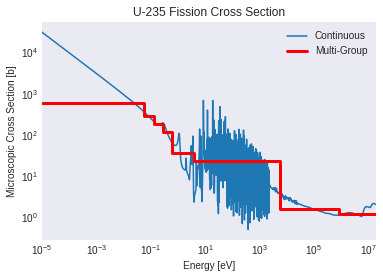

In [29]:
# Create a figure of the U-235 continuous-energy fission cross section 
fig = openmc.plot_xs('U235', ['fission'])

# Get the axis to use for plotting the MGXS
ax = fig.gca()

# Extract energy group bounds and MGXS values to plot
fission = xs_library[fuel_cell.id]['fission']
energy_groups = fission.energy_groups
x = energy_groups.group_edges
y = fission.get_xs(nuclides=['U235'], order_groups='decreasing', xs_type='micro')
y = np.squeeze(y)

# Fix low energy bound
x[0] = 1.e-5

# Extend the mgxs values array for matplotlib's step plot
y = np.insert(y, 0, y[0])

# Create a step plot for the MGXS
ax.plot(x, y, drawstyle='steps', color='r', linewidth=3)

ax.set_title('U-235 Fission Cross Section')
ax.legend(['Continuous', 'Multi-Group'])
ax.set_xlim((x.min(), x.max()))

Another useful type of illustration is scattering matrix sparsity structures. First, we extract Pandas `DataFrames` for the H-1 and O-16 scattering matrices.

In [30]:
# Construct a Pandas DataFrame for the microscopic nu-scattering matrix
nuscatter = xs_library[moderator_cell.id]['nu-scatter']
df = nuscatter.get_pandas_dataframe(xs_type='micro')

# Slice DataFrame in two for each nuclide's mean values
h1 = df[df['nuclide'] == 'H1']['mean']
o16 = df[df['nuclide'] == 'O16']['mean']

# Cast DataFrames as NumPy arrays
h1 = h1.values
o16 = o16.values

# Reshape arrays to 2D matrix for plotting
h1.shape = (fine_groups.num_groups, fine_groups.num_groups)
o16.shape = (fine_groups.num_groups, fine_groups.num_groups)

Matplotlib's `imshow` routine can be used to plot the matrices to illustrate their sparsity structures.

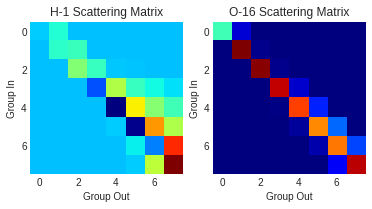

In [31]:
# Create plot of the H-1 scattering matrix
fig = plt.subplot(121)
fig.imshow(h1, interpolation='nearest', cmap='jet')
plt.title('H-1 Scattering Matrix')
plt.xlabel('Group Out')
plt.ylabel('Group In')

# Create plot of the O-16 scattering matrix
fig2 = plt.subplot(122)
fig2.imshow(o16, interpolation='nearest', cmap='jet')
plt.title('O-16 Scattering Matrix')
plt.xlabel('Group Out')
plt.ylabel('Group In')

# Show the plot on screen
plt.show()

In [32]:
# close statepoint file to release HDF5 file handles
sp.close()